## 1. Problem Statement
The project is to predict closing price in Stock market. Prediction is always an interesting topic in ivestment. Investors believe that there is economic cycle in stock market. They would find hints in historical price data. Hence, many financial techique analysis were developed, such as Moving Average. In this project, it will make use of the concept of moving average and develop a LSTM RNN model to predict Closing price with Opening, Highest and Lowest price. 

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-exchange-data/indexProcessed.csv
/kaggle/input/stock-exchange-data/indexData.csv
/kaggle/input/stock-exchange-data/indexInfo.csv


## 2. Exploratory Data Analysis (EDA)
The dataset is reference from Kaggle Dataset: [Stock Exchange Data](https://www.kaggle.com/datasets/mattiuzc/stock-exchange-data) collaborated by Cody. This dataset contains historic data for a variety of stocks exchange market from Yahoo Finance. In this project, we are interested in the Hong Kong Stock Exchange (HSI) from 2011 to 2021. 

In [4]:
#grabing the dataset 
df = pd.read_csv("/kaggle/input/stock-exchange-data/indexData.csv")

#select interested data
HSI = df[df["Index"] == 'HSI']
HSI2011 = HSI[HSI["Date"] >= '2011-01-01']
HSI2011 = HSI2011.dropna()
HSI2011.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
32821,HSI,2011-01-03,23135.64063,23443.52930,23057.51953,23436.05078,23436.05078,1.066930e+09
32822,HSI,2011-01-04,23477.31055,23695.60938,23408.08984,23668.48047,23668.48047,1.330693e+09
32823,HSI,2011-01-05,23650.17969,23773.98047,23579.74023,23757.82031,23757.82031,1.277768e+09
32824,HSI,2011-01-06,23861.22070,23861.22070,23698.38086,23786.30078,23786.30078,1.147689e+09
32825,HSI,2011-01-07,23744.02930,23880.76953,23654.03906,23686.63086,23686.63086,1.287346e+09


#### Data Size
There are 2558 records (rows) and 8 features (columns) in total. The total memory usage of the data is about 179.9KB.

#### Data dimension 
refers to the number of attributes or variables that are being measured for each data point. It can be thought of as the number of columns or features in a dataset. For example, 
The dataset includes information about the index name (HSI), Date, pricing at different stage, and the volume of exchange. The details of explaination are as below:
>* Index: The name of the stock index. In this case, only HSI is stored. It refers to Hang Seng Index, the stock exchange index in Hong Kong.
>* Date: The record date of the exchange. It set from 2011-01-01 to 2021-12-31.
>* Open: The price at the begining of the exchange date.
>* High: The highest price on the exchange date.
>* Low: The lowest price on the exchange date.
>* Close: The price at the end of the exchange date. It is also the target features in this project.
>* Adj Close: Adjusted closing price refers to the price of the stock after paying off the dividends. In this case, it is always as same as the Close
>* Volume: The volume of exchange on the exchange date.

#### Data structure 
There are 2 object features and 6 Float Features in the dataset. All features are non-null value as the rest dates of exchange are excluded.

In [5]:
#Data Infomation
print(HSI2011.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2558 entries, 32821 to 35387
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      2558 non-null   object 
 1   Date       2558 non-null   object 
 2   Open       2558 non-null   float64
 3   High       2558 non-null   float64
 4   Low        2558 non-null   float64
 5   Close      2558 non-null   float64
 6   Adj Close  2558 non-null   float64
 7   Volume     2558 non-null   float64
dtypes: float64(6), object(2)
memory usage: 179.9+ KB
None


#### Descriptive Statistics
The four pricing index are close to each others and having the same trend. The HSI is fraustrated but has a slight upward trend. The highest closing price is 33154.12109, and lowest is 16250.26953. The average of HSI is 24328.96704774824. The volume of exchange are consistant, and have cycle. 

max:  33154.12109
min:  16250.26953
mean:  24328.96704774824


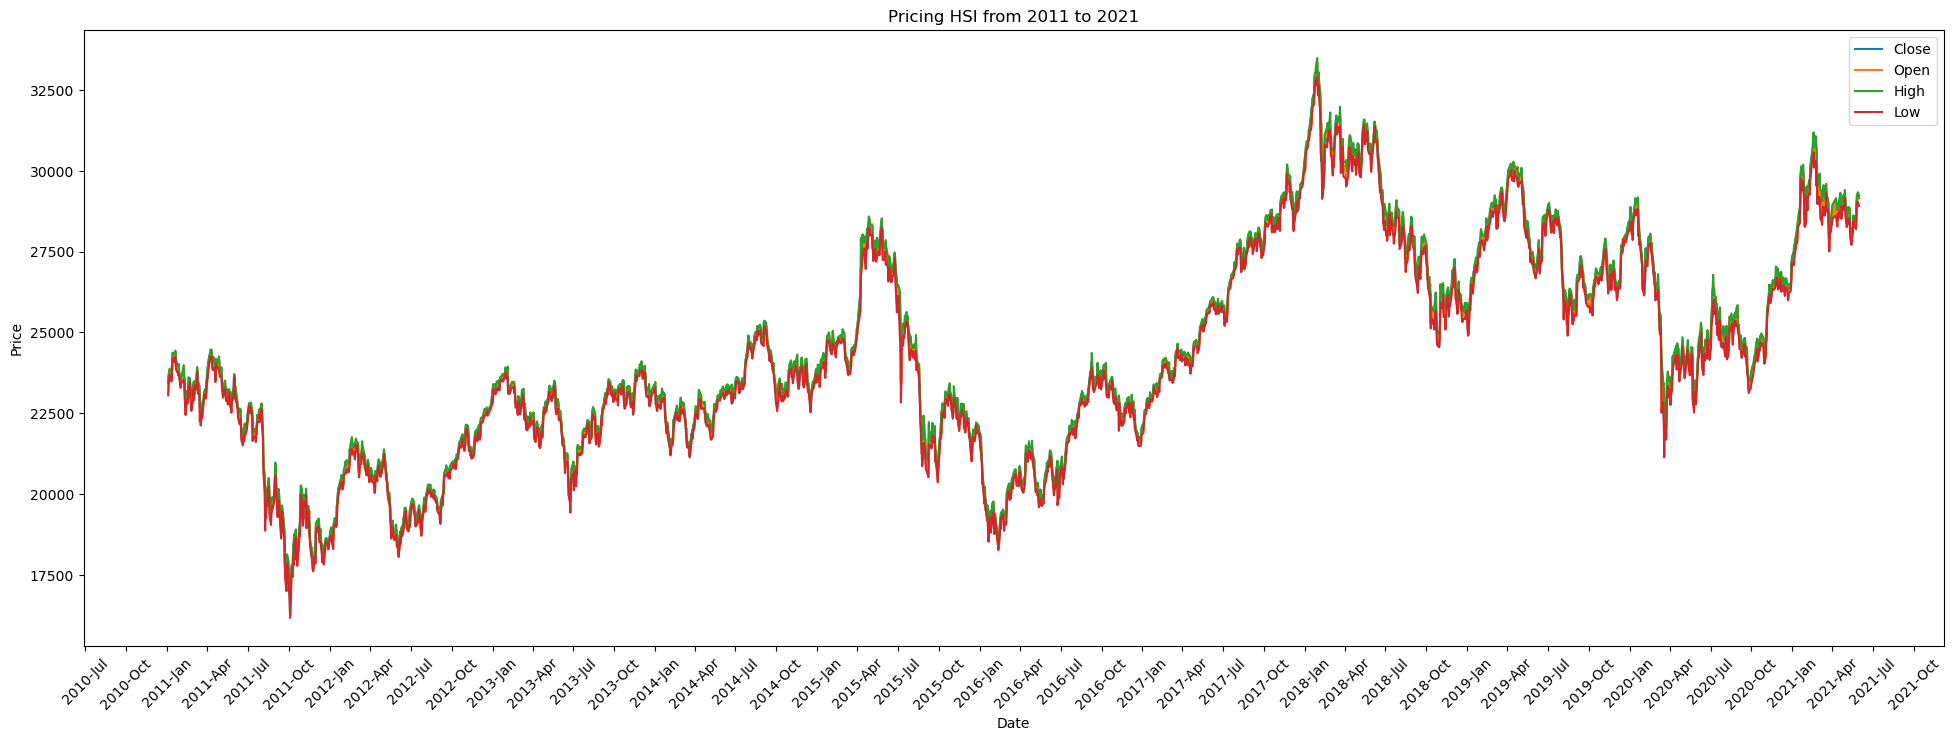

In [6]:
#descriptive data
print("max: ", max(HSI2011['Close']))
print("min: ", min(HSI2011['Close']))
print("mean: ", np.mean(HSI2011['Close']))

#Visualize the dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
HSI2011.loc[: ,"Date"] = pd.to_datetime(HSI2011.loc[: ,"Date"])
plt.figure(figsize=(24,8))
plt.title("Pricing HSI from 2011 to 2021")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(HSI2011['Date'], HSI2011['Close'])
plt.plot(HSI2011['Date'], HSI2011['Open'])
plt.plot(HSI2011['Date'], HSI2011['High'])
plt.plot(HSI2011['Date'], HSI2011['Low'])
plt.legend(["Close","Open","High","Low"])
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every quater 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation = 45)
plt.show()

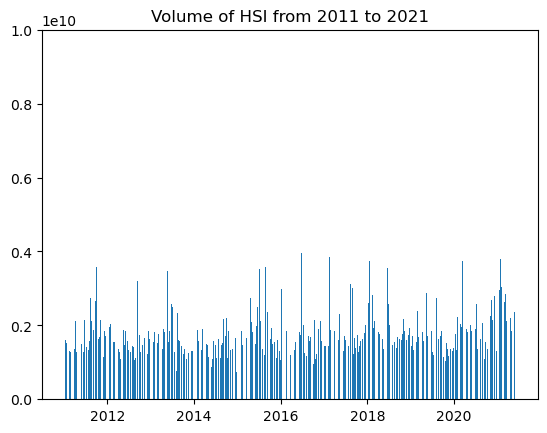

In [7]:
plt.title("Volume of HSI from 2011 to 2021")
plt.bar(HSI2011['Date'], HSI2011['Volume'])
plt.show()

Simple Moving Average is one of the common used technique for investors to predict the price. 10, 20, 50, 100, 200, 250 are the most popular time step used for the indicators.

We could see that MA20 and MA50 are most fit to the HSI without overfitting. We might consider it for the time step of our predict model. 


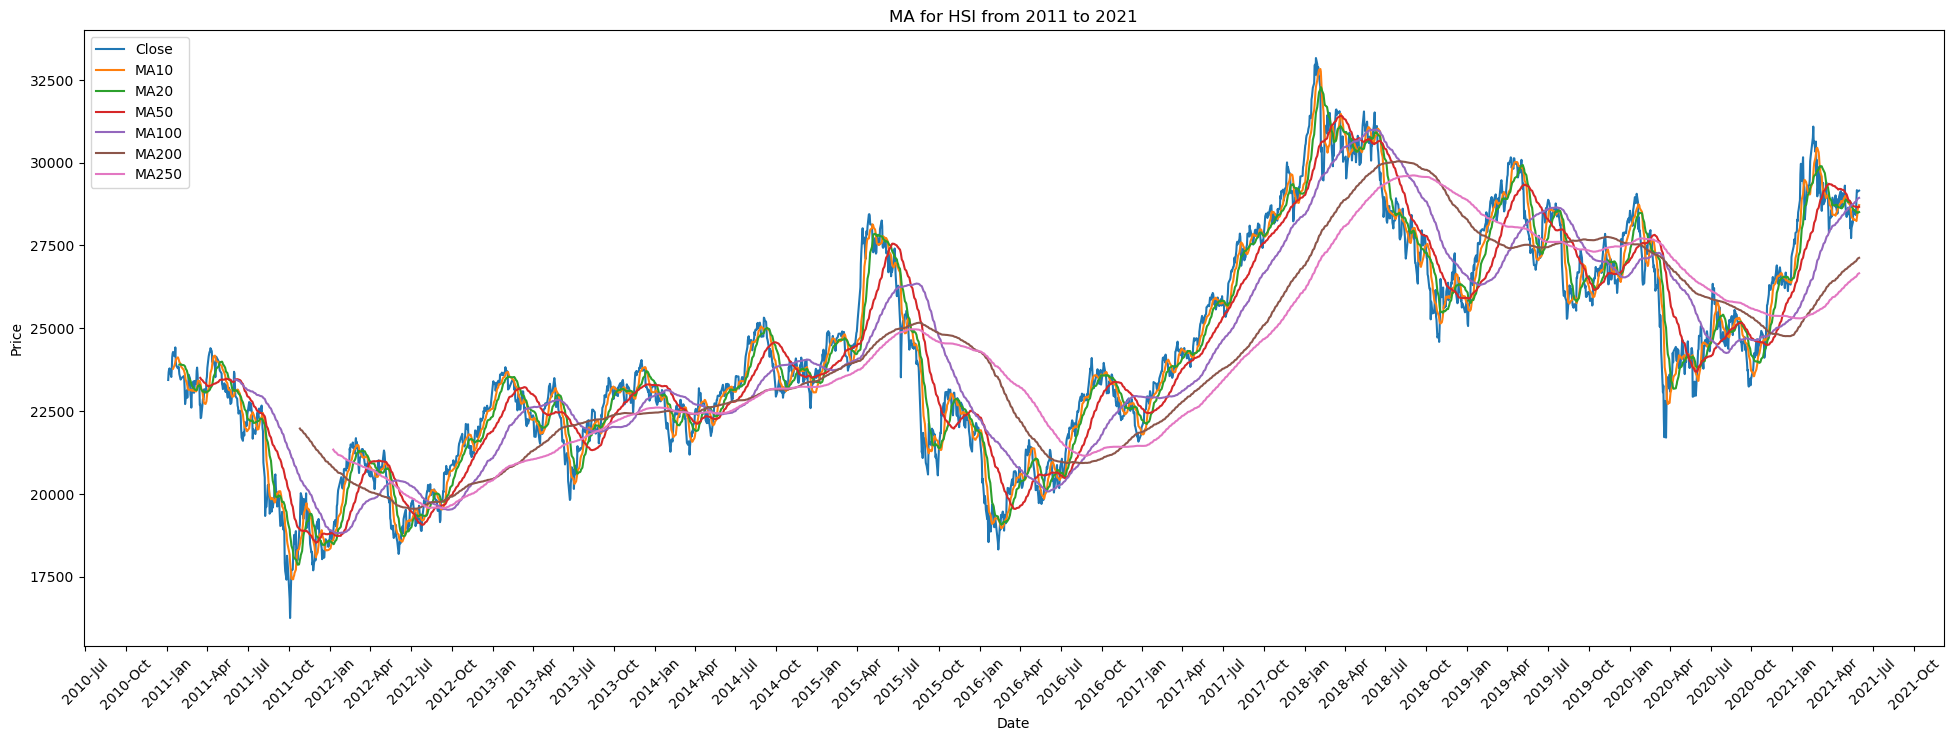

In [8]:
#Simple Moving Average Calculation
def MA(dataset, t):
    MA=np.empty(len(dataset), dtype=object) 
    for i in range(t-1,len(dataset)):
        MA[i]=np.mean(dataset['Close'][i-t+1:i])
        #print(i) 
    return MA 

# find the MA10, MA20, MA50, MA100, MA200, MA250
HSI2011['MA10']=MA(HSI2011,10)
HSI2011['MA20']=MA(HSI2011,20)
HSI2011['MA50']=MA(HSI2011,50)
HSI2011['MA100']=MA(HSI2011,100)
HSI2011['MA200']=MA(HSI2011,200)
HSI2011['MA250']=MA(HSI2011,250)

#plot the MA
plt.figure(figsize=(24,8))
plt.title("MA for HSI from 2011 to 2021")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(HSI2011['Date'], HSI2011['Close'])
plt.plot(HSI2011['Date'], HSI2011['MA10'])
plt.plot(HSI2011['Date'], HSI2011['MA20'])
plt.plot(HSI2011['Date'], HSI2011['MA50'])
plt.plot(HSI2011['Date'], HSI2011['MA100'])
plt.plot(HSI2011['Date'], HSI2011['MA200'])
plt.plot(HSI2011['Date'], HSI2011['MA250'])
plt.legend(["Close","MA10","MA20","MA50","MA100","MA200","MA250"])
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every quater 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation = 45)
plt.show()

#### Pre-proceed data
First, The data will be splited into Training, Validation and Testing Data set. The Testing Data set will use the HSI since 2020. The rest of the data (2011-2019) will be used for training and validation. The data in 2011-2019, 20% will be used for validation. As a result, 348 testing data, and 2210 training and validation data.

Second, due to the charaatics of the data features, Adj Close, Index, Date will be drop out. They are not affecting the prediction and waste calucation resources. Then reshape the training dataset by desired time steps.

Last, to converge faster and stablize the gradient descent step. It is going to normalize the data scale with normalization layer.

In [9]:
# grab data for training data
train_data = HSI2011[HSI2011["Date"] < '2020-01-01'].reset_index(drop=True)
print(train_data.head())

def dataPreproceed(data_set, timestep):
    global x_train
    global y_train
    
    #grab the interested pricing and volumn (dropout Adj Close, Index, Date and the MAs) 
    new_data_x = data_set[["Open", "High", "Low", "Volume"]]
    new_data_y = np.asarray(data_set['Close'])
    
    #reshape with desired input shape 
    for i in range(timestep, len(new_data_x)):
        x_train.append(new_data_x[i-timestep:i])
        y_train.append(new_data_y[i])
        
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    print(x_train.shape)
    print(y_train.shape)
    return 

# pre-proceed the data
x_train=[]
y_train=[]
timestep = 20
dataPreproceed(train_data, timestep)


  Index       Date         Open         High          Low        Close  \
0   HSI 2011-01-03  23135.64063  23443.52930  23057.51953  23436.05078   
1   HSI 2011-01-04  23477.31055  23695.60938  23408.08984  23668.48047   
2   HSI 2011-01-05  23650.17969  23773.98047  23579.74023  23757.82031   
3   HSI 2011-01-06  23861.22070  23861.22070  23698.38086  23786.30078   
4   HSI 2011-01-07  23744.02930  23880.76953  23654.03906  23686.63086   

     Adj Close        Volume  MA10  MA20  MA50 MA100 MA200 MA250  
0  23436.05078  1.066930e+09  None  None  None  None  None  None  
1  23668.48047  1.330693e+09  None  None  None  None  None  None  
2  23757.82031  1.277768e+09  None  None  None  None  None  None  
3  23786.30078  1.147689e+09  None  None  None  None  None  None  
4  23686.63086  1.287346e+09  None  None  None  None  None  None  
(2190, 20, 4)
(2190,)


## 3. Model Architecture
As mentioned, we assume that the stock price has correlation in historical data. It indicates that it is a time series problem. LSTM in RNN is suggested for this problem. This approach consider the time effect on the output. The suggested Architecture is as follow:
> Input -> LSTM -> BatchNormalization -> Dropout -> Dense(4)* -> Dense(1) -> Output

*The first Dense layer is set as 4 becuase of 4 input features.

#### Return_sequences 
It will be set as **FALSE** as the order sequence is important for stock and would not have effect when return back.

#### Activation Function and Optimization Method
According to Masud Rana (2019), Adam optimizator and tanh for LSTM layer preformed the best. Hence, this project will adopt in this setting as initiation. 

#### Time Step and the Units of LSTM
As discussed, the moving average performs well at **20** and **50**. Referring this setting. This project will try the **20** and **50** time step with the same units of LSTM. Some analysist would like to use both indicators at the same time. Hence, this project will try multiple LSTM layers with **50** and **20** units. The first layer will set return_sequences as **TRUE**.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

learning_rate = 0.01
validationSplit = 0.2 
epochs = 100
batch = 64

#build the first model with 20 time step approach
model_20 = keras.Sequential()
model_20.add(layers.LSTM(units = x_train.shape[1], return_sequences = False, input_shape = (x_train.shape[1],x_train.shape[2]), activation='tanh'))
model_20.add(layers.BatchNormalization())
model_20.add(layers.Dropout(0.5))
model_20.add(layers.Dense(x_train.shape[2]))
model_20.add(layers.Dense(1))
model_20.build()
model_20.summary()

opt = Adam(learning_rate=learning_rate)
model_20.compile(optimizer=opt, loss='mean_absolute_error')
hist_20 = model_20.fit(x_train, y_train, batch_size = batch, validation_split = validationSplit, epochs = epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2000      
                                                                 
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 2,169
Trainable params: 2,129
Non-trainable params: 40
_____________________________________________________

In [11]:
# pre-proceed the data
x_train=[]
y_train=[]
timestep = 50
dataPreproceed(train_data, timestep)

#build the second model with 50 time step approach
model_50 = keras.Sequential()
model_50.add(layers.LSTM(units = x_train.shape[1], return_sequences = False, input_shape = (x_train.shape[1],x_train.shape[2]), activation='tanh'))
model_50.add(layers.BatchNormalization())
model_50.add(layers.Dropout(0.5))
model_50.add(layers.Dense(x_train.shape[2]))
model_50.add(layers.Dense(1))
model_50.build()
model_50.summary()

opt = Adam(learning_rate=learning_rate)
model_50.compile(optimizer=opt, loss='mean_absolute_error')
hist_50 = model_50.fit(x_train, y_train, batch_size = batch, validation_split = validationSplit, epochs = epochs)

(2160, 50, 4)
(2160,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11000     
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 11,409
Trainable params: 11,309
Non-trainable params: 100
__________________________

In [12]:
# pre-proceed the data
x_train=[]
y_train=[]
timestep = 50
dataPreproceed(train_data, timestep)

#build the third model with mixed approach
model_mix = keras.Sequential()
model_mix.add(layers.LSTM(units = x_train.shape[1], return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2]), activation='tanh'))
model_mix.add(layers.BatchNormalization())
model_mix.add(layers.Dropout(0.5))

model_mix.add(layers.LSTM(units = 20, return_sequences = False, input_shape = (x_train.shape[1],x_train.shape[2]), activation='tanh'))
model_mix.add(layers.BatchNormalization())
model_mix.add(layers.Dropout(0.5))
model_mix.add(layers.Dense(x_train.shape[2]))
model_mix.add(layers.Dense(1))
model_mix.build()
model_mix.summary()

opt = Adam(learning_rate=learning_rate)
model_mix.compile(optimizer=opt, loss='mean_absolute_error')
hist_mix = model_mix.fit(x_train, y_train, batch_size = batch, validation_split = validationSplit, epochs = epochs)

(2160, 50, 4)
(2160,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            11000     
                                                                 
 batch_normalization_2 (Batc  (None, 50, 50)           200       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                5680      
                                                                 
 batch_normalization_3 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (No

## 4. Result and Analysis
All model perform good learning. The model mixed and 20 time step performed better. However all of them show overfitting after 10 epoches. The model mixed is less serious. Hence, Model mixed would be chosen for testing prediction.

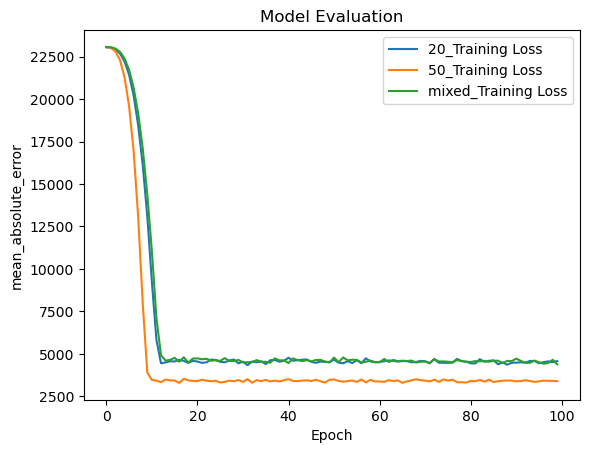

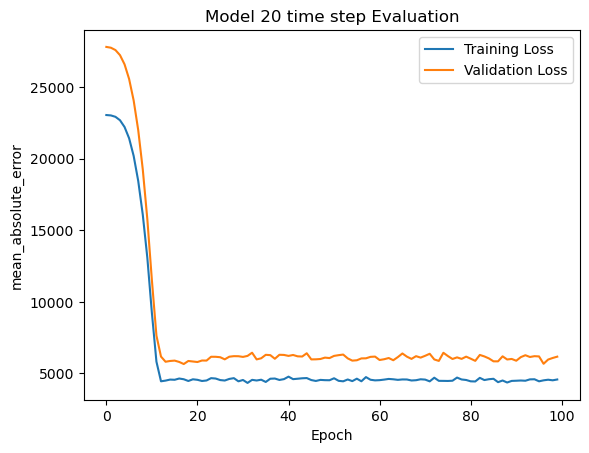

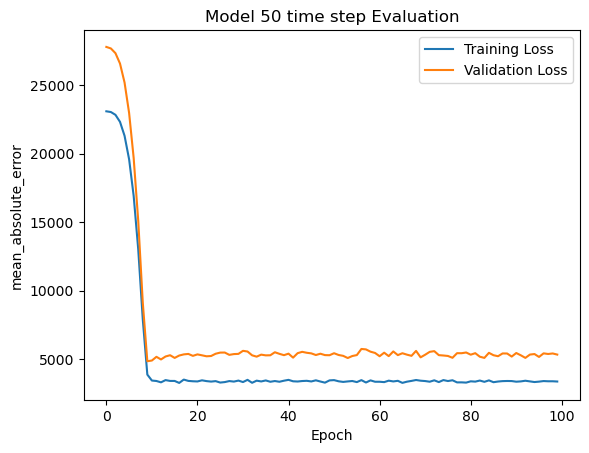

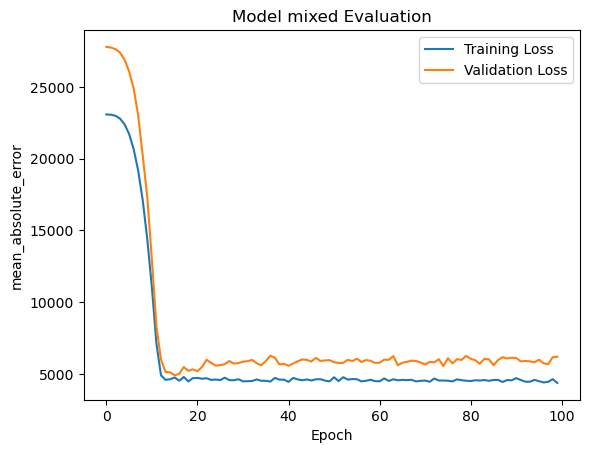

In [13]:
plt.plot(hist_20.history["loss"])

plt.plot(hist_50.history["loss"])

plt.plot(hist_mix.history["loss"])

plt.title("Model Evaluation")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epoch")
plt.legend(["20_Training Loss", "50_Training Loss","mixed_Training Loss"])
plt.show()

plt.plot(hist_20.history["loss"])
plt.plot(hist_20.history['val_loss'])
plt.title("Model 20 time step Evaluation")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation Loss"])
plt.show()

plt.plot(hist_50.history["loss"])
plt.plot(hist_50.history['val_loss'])
plt.title("Model 50 time step Evaluation")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation Loss"])
plt.show()

plt.plot(hist_mix.history["loss"])
plt.plot(hist_mix.history['val_loss'])
plt.title("Model mixed Evaluation")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation Loss"])
plt.show()

## 5. Prediction for Testing
The Testing Data set will use the HSI since 2020. The rest of the data (2011-2019) is used for testing data. There are 348 entries. The model mixed and 50 time steps would be used.

In [35]:
# grab data for testing data
test_data = HSI2011[HSI2011["Date"] >= '2020-01-01'].reset_index(drop=True)
print(test_data.info())
x_train=[]
y_train=[]
timestep = 50
dataPreproceed(test_data, timestep)

#predict for testing
predictions = model_mix.predict(x_train, verbose=1)
predictions = np.transpose(predictions)
print(predictions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Index      348 non-null    object        
 1   Date       348 non-null    datetime64[ns]
 2   Open       348 non-null    float64       
 3   High       348 non-null    float64       
 4   Low        348 non-null    float64       
 5   Close      348 non-null    float64       
 6   Adj Close  348 non-null    float64       
 7   Volume     348 non-null    float64       
 8   MA10       348 non-null    object        
 9   MA20       348 non-null    object        
 10  MA50       348 non-null    object        
 11  MA100      348 non-null    object        
 12  MA200      348 non-null    object        
 13  MA250      348 non-null    object        
dtypes: datetime64[ns](1), float64(6), object(7)
memory usage: 38.2+ KB
None
(298, 50, 4)
(298,)
10/10 [==============================] - 0s 15

MAE: 4580.389622516779


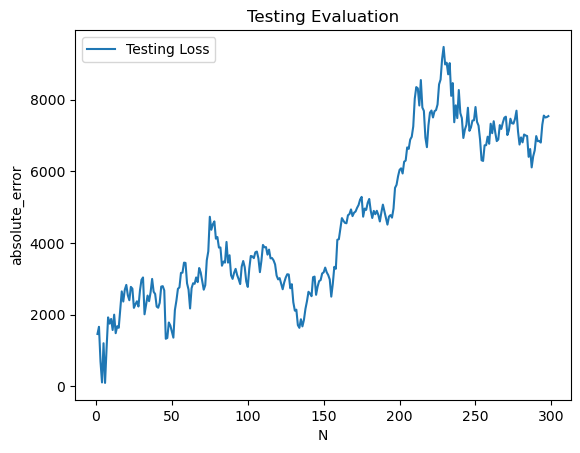

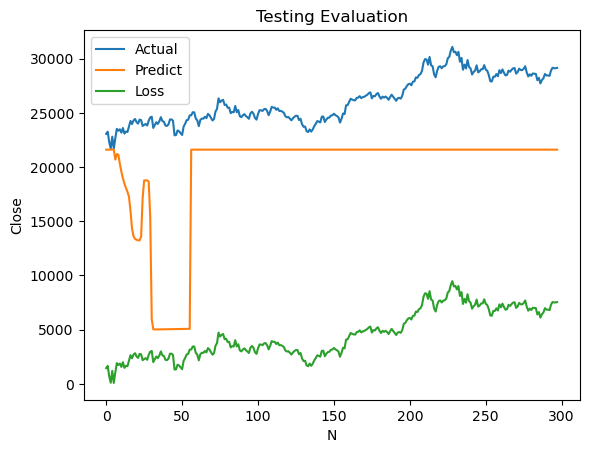

In [34]:
#Evaluate the testing result
ae = np.abs(predictions-y_train)
print('MAE:', np.mean(ae[0]))
x = np.arange(1, len(ae[0])+1)
plt.plot(x, ae[0])
plt.title("Testing Evaluation")
plt.ylabel("absolute_error")
plt.xlabel("N")
plt.legend(["Testing Loss"])
plt.show()

plt.plot(y_train)
plt.plot(predictions)
plt.plot(ae[0])
plt.title("Testing Evaluation")
plt.ylabel("Close")
plt.xlabel("N")
plt.legend(["Actual", "Predict", 'Loss'])
plt.show()

## 6. Conclusion
As a result, the model perform well at the first few time step. After the 50 time step, it return constant. The MAE is 4580.389622516779. The model is overfitted and not accurate as expected. The architecure and parameters (units of Dropout and LSTM layer) an should be modified to improve. 